## Изучение исходных данных

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import optuna
import time
import matplotlib.pyplot as plt

from optuna.integration import OptunaSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
encoder = OrdinalEncoder()
opt_distr_int = optuna.distributions.IntUniformDistribution
opt_distr_float = optuna.distributions.UniformDistribution

# Настроим параметры
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['axes.grid'] = True
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 0)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
# Загрузим данные
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

data_list = [contract, personal, internet, phone]

In [5]:
for data in data_list:
    display(data.head())
    data.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Хорошие новости - явных пропусков в данных нет. Необходимо углубить исследование данных на ошибки/пропуски/дубликаты

In [6]:
# Заменим в каждой таблице названия столбцов на snake_case:
for data in data_list:
    data.columns = data.columns.str.lower()

## Предоработка данных

In [7]:
# Сверим каждую таблицу на дублирующих пользователей:
for data in data_list:
    print('Количество дубликатов:',data.customerid.duplicated().sum())

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


In [8]:
# Рассмоттрим таблицы на наличие неявных пропусков/дубликатов:
for column in ['type', 'paperlessbilling', 'paymentmethod']:
    print(f'Уникальные значения колонки {column} таблицы contract:', contract[column].unique(), '\n')

Уникальные значения колонки type таблицы contract: ['Month-to-month' 'One year' 'Two year'] 

Уникальные значения колонки paperlessbilling таблицы contract: ['Yes' 'No'] 

Уникальные значения колонки paymentmethod таблицы contract: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 



In [9]:
for column in personal.columns[1:]:
    print(f'Уникальные значения колонки {column} таблицы personal:', personal[column].unique(), '\n')

Уникальные значения колонки gender таблицы personal: ['Female' 'Male'] 

Уникальные значения колонки seniorcitizen таблицы personal: [0 1] 

Уникальные значения колонки partner таблицы personal: ['Yes' 'No'] 

Уникальные значения колонки dependents таблицы personal: ['No' 'Yes'] 



In [10]:
for column in internet.columns[1:]:
    print(f'Уникальные значения колонки {column} таблицы internet:', internet[column].unique(), '\n')

Уникальные значения колонки internetservice таблицы internet: ['DSL' 'Fiber optic'] 

Уникальные значения колонки onlinesecurity таблицы internet: ['No' 'Yes'] 

Уникальные значения колонки onlinebackup таблицы internet: ['Yes' 'No'] 

Уникальные значения колонки deviceprotection таблицы internet: ['No' 'Yes'] 

Уникальные значения колонки techsupport таблицы internet: ['No' 'Yes'] 

Уникальные значения колонки streamingtv таблицы internet: ['No' 'Yes'] 

Уникальные значения колонки streamingmovies таблицы internet: ['No' 'Yes'] 



In [11]:
for column in phone.columns[1:]:
    print(f'Уникальные значения колонки {column} таблицы phone:', phone[column].unique())

Уникальные значения колонки multiplelines таблицы phone: ['No' 'Yes']


In [12]:
contract.begindate.unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [13]:
# Приведём столбец к необходимому типу:
contract.begindate = pd.to_datetime(contract.begindate, format='%Y-%m-%d')

In [14]:
contract.enddate.unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Интересно, пользователи стали уходить только к концу 2019-го года. Возможно это указывает на синтетическую природу данных, но можно и углубить анализ для выяснения причин.

In [15]:
# Рассмотрим сумму тотальных платежей на определение ошибок:
sorted(contract.totalcharges.unique())

[' ',
 '100.2',
 '100.25',
 '100.35',
 '100.4',
 '100.8',
 '100.9',
 '1001.2',
 '1001.5',
 '1003.05',
 '1004.35',
 '1004.5',
 '1004.75',
 '1005.7',
 '1006.9',
 '1007.8',
 '1007.9',
 '1008.55',
 '1008.7',
 '1009.25',
 '101.1',
 '101.45',
 '101.65',
 '101.9',
 '1010',
 '1011.05',
 '1011.5',
 '1011.8',
 '1012.4',
 '1013.05',
 '1013.2',
 '1013.35',
 '1013.6',
 '1014.25',
 '1016.7',
 '1017.35',
 '102.45',
 '102.5',
 '102.75',
 '1020.2',
 '1020.75',
 '1021.55',
 '1021.75',
 '1021.8',
 '1022.5',
 '1022.6',
 '1022.95',
 '1023.75',
 '1023.85',
 '1023.9',
 '1023.95',
 '1024',
 '1024.65',
 '1024.7',
 '1025.05',
 '1025.15',
 '1025.95',
 '1026.35',
 '1027.25',
 '1028.75',
 '1028.9',
 '1029.35',
 '1029.75',
 '1029.8',
 '103.7',
 '1031.1',
 '1031.4',
 '1031.7',
 '1032',
 '1032.05',
 '1033',
 '1033.9',
 '1033.95',
 '1035.5',
 '1035.7',
 '1036',
 '1036.75',
 '1037.75',
 '1039.45',
 '104.2',
 '104.3',
 '1041.8',
 '1042.65',
 '1043.3',
 '1043.35',
 '1043.4',
 '1043.8',
 '1045.25',
 '1046.1',
 '1046.2',
 

In [16]:
contract.query('totalcharges==" "')

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как видно, данных о тотальных платежах нет о новых пользователей, присоединившихся в феврале. Видится безопасным присвоить им соответствующий ежемесячный платёж в столбце TotalCharges.

In [17]:
contract.loc[contract['totalcharges']==" ",'totalcharges'] = contract.loc[contract['totalcharges']==" ",'monthlycharges']
contract.totalcharges = contract.totalcharges.astype('float64')

In [18]:
# Проверим, нет ли ошибок в соотношении тотальных и ежемесячных платежей:
contract.query('totalcharges < monthlycharges')

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges


Данные прошли предобработку, можно приступать к анализу 

## Исследовательский анализ

Наша целевая переменная - покинул ли компанию пользователь или нет. Введём эту переменную в исследуемые данные

In [19]:
contract['churn'] = np.where(contract['enddate']!='No',1,0)

personal = personal.merge(contract.loc[:,['customerid', 'churn']], how='inner', on='customerid')

internet = internet.merge(contract.loc[:,['customerid', 'churn']], how='inner', on='customerid')

phone = phone.merge(contract.loc[:,['customerid', 'churn']], how='inner', on='customerid')

In [20]:
# Рассмотрим соотношение классов в целевой переменной:
(contract.groupby('churn')['customerid'].count()/len(contract)).map('{:.2%}'.format)

churn
0    73.46%
1    26.54%
Name: customerid, dtype: object

Имеется дисбаланс, необходима стратификация при отборе на трейн/тест выборки, предпочтение при построении моделей следует отдать деревянным типам.

### Анализ количественных данных

Проверим количественные данные на аномалии/выбросы:

In [21]:
contract[['monthlycharges','totalcharges']].describe()

,monthlycharges,totalcharges
count,7043.000000,7043.000000
mean,64.761692,2279.798992
std,30.090047,2266.730170
min,18.250000,18.800000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


С первого взгляда аномалий/выбросов в данных не видно. Удостоверимся в этом построением диаграммы размаха

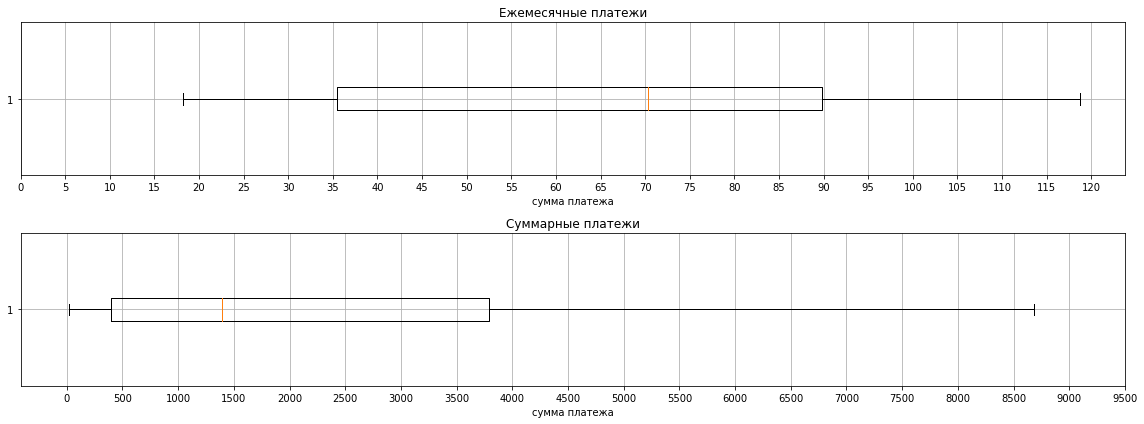

In [22]:
plt.subplot(2,1,1)
plt.title('Ежемесячные платежи')
plt.boxplot(contract.monthlycharges, vert=False)
plt.xlabel('сумма платежа')
plt.xticks(range(0,125,5))
plt.subplot(2,1,2)
plt.title('Суммарные платежи')
plt.boxplot(contract.totalcharges, vert=False)
plt.xlabel('сумма платежа')
plt.xticks(range(0,10000,500))
plt.tight_layout()
plt.show()

Все значения количественных данных находятся в пределах нормальных значений

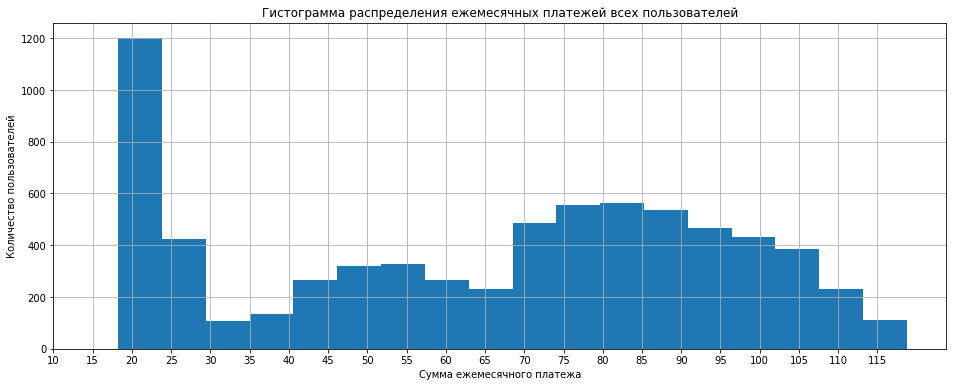

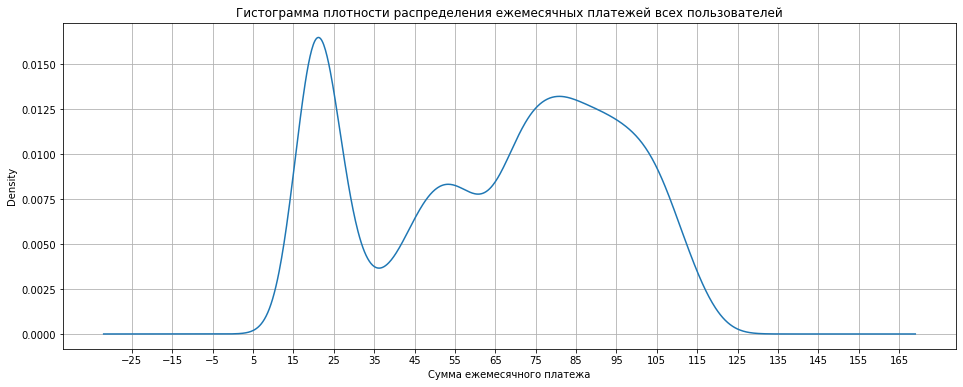

In [23]:
plt.hist(contract.monthlycharges, bins='auto')
plt.title('Гистограмма распределения ежемесячных платежей всех пользователей')
plt.xlabel('Сумма ежемесячного платежа')
plt.ylabel('Количество пользователей')
plt.xticks(range(10,120,5))
plt.show()
contract.monthlycharges.plot(kind='kde')
plt.title('Гистограмма плотности распределения ежемесячных платежей всех пользователей')
plt.xlabel('Сумма ежемесячного платежа')
plt.xticks(range(-25,175,10))
plt.show()

При рассмотрении гистограмм представляется возможным выделить три подгруппы по сумме ежемесячного платежа, видимо концетрирующиеся около предложенных тарифов (с отклонениями в виде дополнительных услуг) - это подгруппы вокруг (20-30), (50-60) и (75-90).

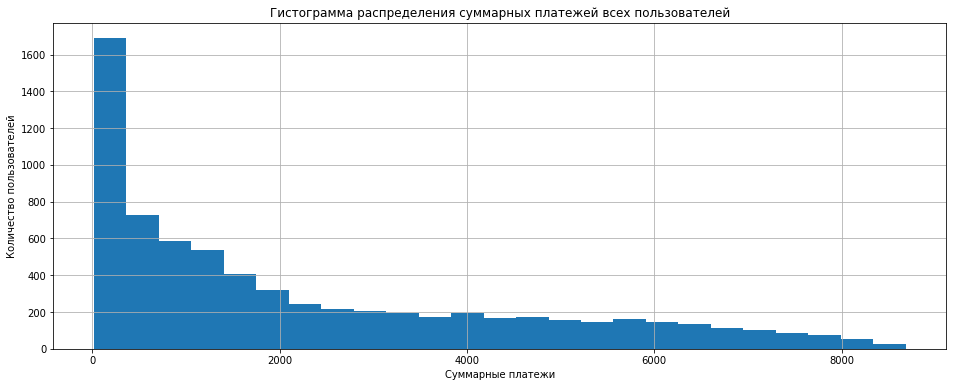

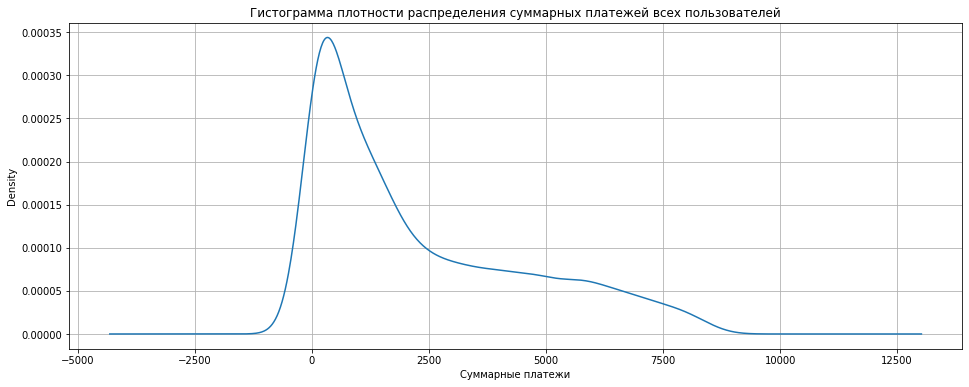

In [24]:
plt.hist(contract.totalcharges, bins='auto')
plt.title('Гистограмма распределения суммарных платежей всех пользователей')
plt.xlabel('Суммарные платежи')
plt.ylabel('Количество пользователей')
plt.show()
contract.totalcharges.plot(kind='kde')
plt.title('Гистограмма плотности распределения суммарных платежей всех пользователей')
plt.xlabel('Суммарные платежи')
plt.show()

Данные гистограммы очевидным образом свидетельствуют о линейной зависимости количества пользователей и объёму суммарных платежей.

### Оценка влияния признаков на целевую переменную

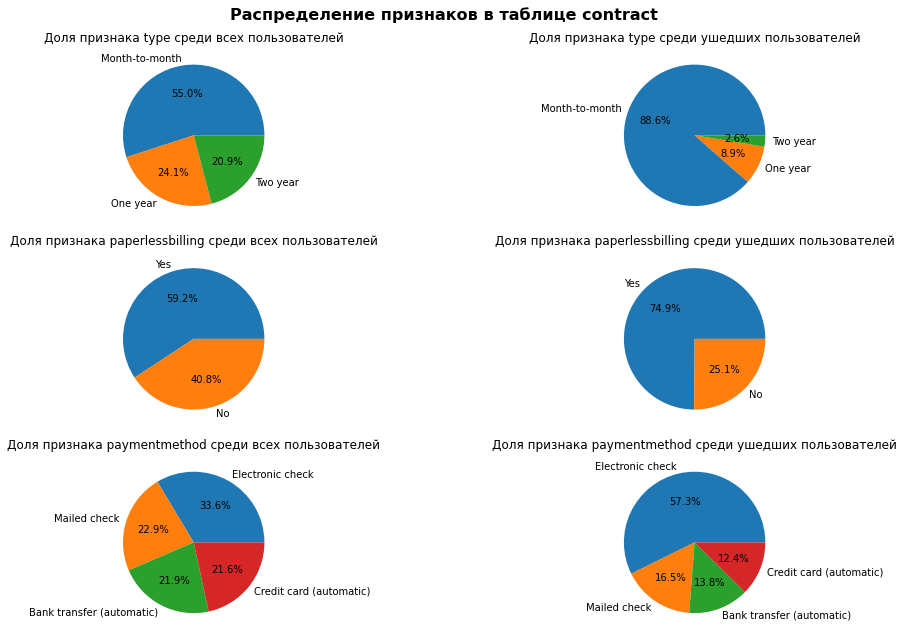

In [25]:
i = 0
plt.figure(figsize=(16,9))
for column in contract.columns[3:6]:
    plt.subplot(321 + i)
    plt.pie(
        x=contract[column].value_counts(normalize=True),
        labels=contract[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди всех пользователей')
    i += 1
    plt.subplot(321 + i)
    plt.pie(
        x=contract.query('churn==1')[column].value_counts(normalize=True),
        labels=contract[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди ушедших пользователей')
    i += 1
plt.suptitle('Распределение признаков в таблице contract', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Судя по графикам, все признаки оказывают то или иное влияние на целевую переменную

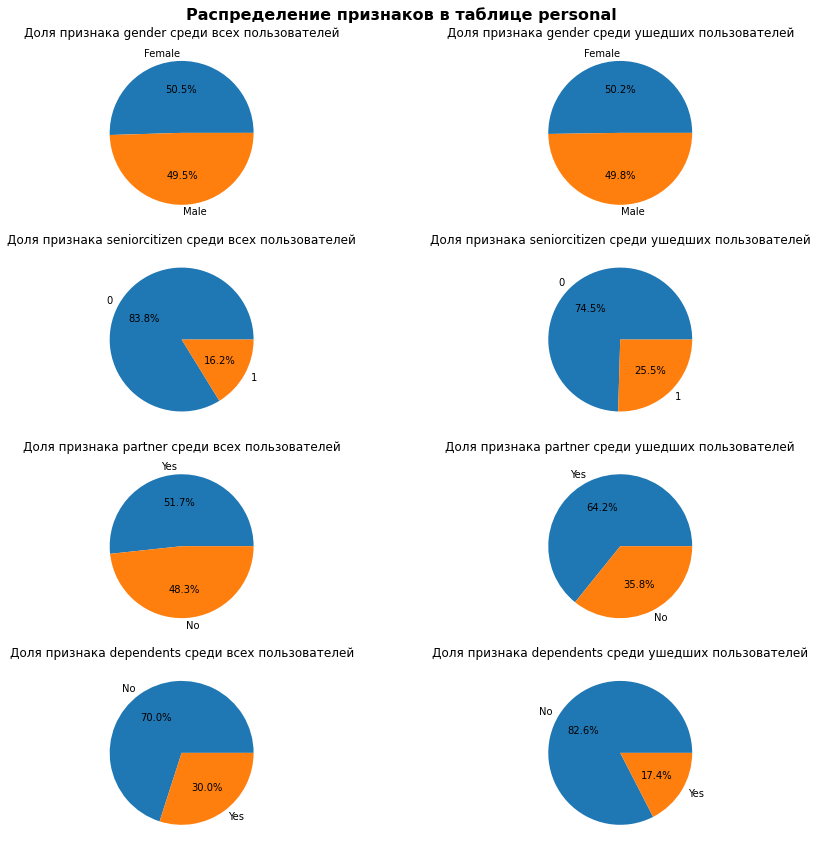

In [26]:
i = 0
plt.figure(figsize=(16,12))
for column in personal.columns[1:-1]:
    plt.subplot(421 + i)
    plt.pie(
        x=personal[column].value_counts(normalize=True),
        labels=personal[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди всех пользователей')
    i += 1
    plt.subplot(421 + i)
    plt.pie(
        x=personal.query('churn==1')[column].value_counts(normalize=True),
        labels=personal[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди ушедших пользователей')
    i += 1
plt.suptitle('Распределение признаков в таблице personal', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Как можно видеть, среди рассмотренных признаков, только признак пола практически не влияет на отток клиентов

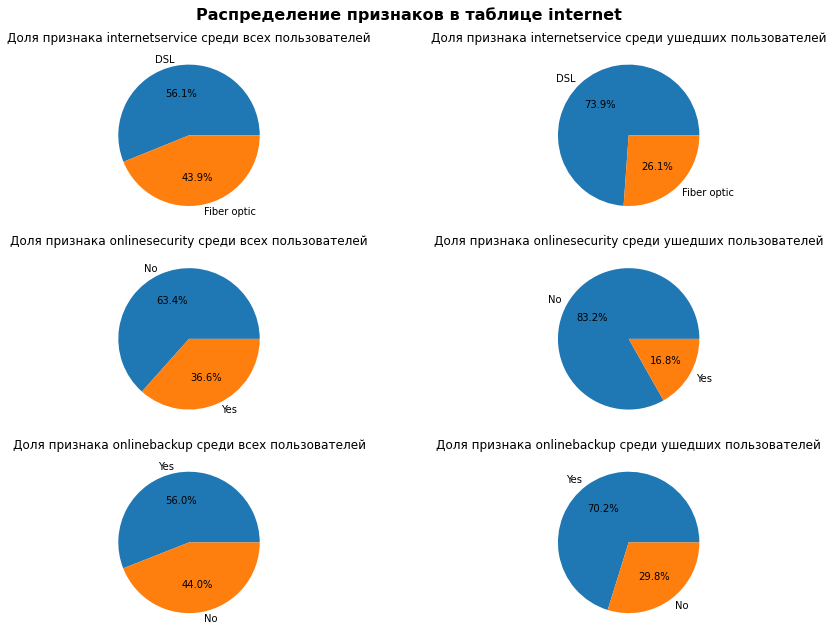

In [27]:
i = 0
plt.figure(figsize=(16,9))
for column in internet.columns[1:4]:
    plt.subplot(321 + i)
    plt.pie(
        x=internet[column].value_counts(normalize=True),
        labels=internet[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди всех пользователей')
    i += 1
    plt.subplot(321 + i)
    plt.pie(
        x=internet.query('churn==1')[column].value_counts(normalize=True),
        labels=internet[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди ушедших пользователей')
    i += 1
plt.suptitle('Распределение признаков в таблице internet', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

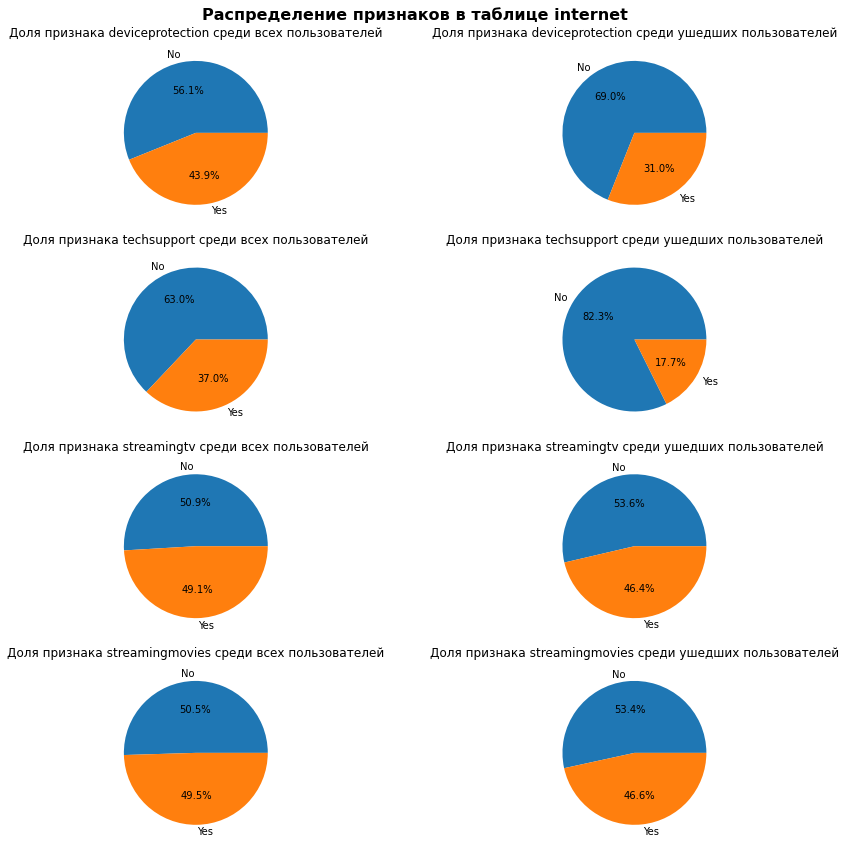

In [28]:
i = 0
plt.figure(figsize=(16,12))
for column in internet.columns[4:-1]:
    plt.subplot(421 + i)
    plt.pie(
        x=internet[column].value_counts(normalize=True),
        labels=internet[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди всех пользователей')
    i += 1
    plt.subplot(421 + i)
    plt.pie(
        x=internet.query('churn==1')[column].value_counts(normalize=True),
        labels=internet[column].unique(),
        autopct="%1.1f%%")
    plt.title(f'Доля признака {column} среди ушедших пользователей')
    i += 1
plt.suptitle('Распределение признаков в таблице internet', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Из рассмотренных признаков пользование стриминговыми сервисами слабее всего связано с целевым признаком

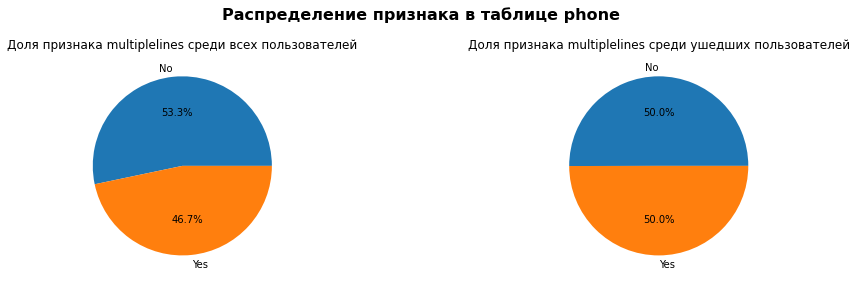

In [29]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.pie(
    x=phone['multiplelines'].value_counts(normalize=True),
    labels=phone['multiplelines'].unique(),
    autopct="%1.1f%%")
plt.title(f'Доля признака multiplelines среди всех пользователей')
plt.subplot(122)
plt.pie(
    x=phone.query('churn==1')['multiplelines'].value_counts(normalize=True),
    labels=phone['multiplelines'].unique(),
    autopct="%1.1f%%")
plt.title(f'Доля признака multiplelines среди ушедших пользователей')
plt.suptitle('Распределение признака в таблице phone', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Наличие множественных линей среди пользователей, пользующихся телефоном, слабо связано с оттоком клиентов.

## Подготовка данных

In [30]:
# Составим полную таблицу
full_data = contract.copy()
for data in data_list[1:]:
    full_data = full_data.merge(data, on='customerid', how='left')

В связи с тем, что не все клиенты пользуются телефонной связью/интернетом, у нас образовались пропуски в соответствующих столбцах при сращивании таблиц phone и internet. Заполним их дополнительным значением 'Not Used'

In [31]:
full_data = full_data.fillna('Not Used')

### Feature engineering

Определим время обслуживания клиента

In [32]:
full_data.enddate = full_data.enddate.replace('No', '2020-02-01')
full_data.enddate = pd.to_datetime(full_data.enddate, format='%Y-%m-%d')

In [33]:
full_data['servicedays'] = (full_data['enddate']-full_data['begindate']).astype('timedelta64[D]').astype('int')

full_data['servicemonths'] = (full_data['enddate']-full_data['begindate']).astype('timedelta64[M]').astype('int')

full_data['serviceyears'] = (full_data['enddate']-full_data['begindate']).astype('timedelta64[Y]').astype('int')

Избавимся от следующих признаков:

- Неинформативные: customerid, gender
- Ненужные: begindate, enddate
- Взаимосвязанные: Из totalcharges и monthlycharges удалим второй

In [34]:
full_data = full_data.drop(['customerid', 'begindate', 'enddate', 'monthlycharges', 'gender'], axis=1)

### Кодировка признаков

In [35]:
num_features = ['totalcharges', 'servicedays', 'servicemonths', 'serviceyears']
encoded_data = encoder.fit_transform(
    full_data.drop(num_features, axis=1)
    )

encoded_data = (pd.DataFrame(
    encoded_data,
    columns=full_data.drop(num_features,axis=1).columns)
                .join(full_data[num_features]))

### Составление выборок

In [36]:
features = encoded_data.drop(['churn'], axis=1)
target = encoded_data['churn']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=777)

## Построение моделей

In [38]:
# Определим функцию для визуализации roc_auc:
def roc_auc_plot(model, size=(8,8)):
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure(figsize=size)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
    plt.plot(fpr, tpr, label=type(model).__name__ )
    plt.xlim([0, 1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.ylim([0, 1])
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

In [39]:
# Определим функцию для визуализации важности фичей:
def feat_importance_plot(model, feature_names=None):
    feature_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values()
    feature_importances.plot(kind='bar')
    plt.title(f'Важность признаков на модели {type(model).__name__}')
    plt.ylabel('Importance')
    plt.show()

### Логистическая регрессия

In [40]:
logreg_model = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced', max_iter=500, random_state=777)
time_tuning_logreg = None

start_time = time.time()

logreg_model.fit(X_train, y_train)

time_learn_logreg = time.time() - start_time

print(f'Время обучения модели: {time_learn_logreg:.4f}s')

start_time = time.time()

predictions_logreg = logreg_model.predict(X_test)
predictions_proba_logreg = logreg_model.predict_proba(X_test)[:,1]

time_predict_logreg = time.time() - start_time

print(f'Время предсказания модели: {time_predict_logreg:.4f}s \n')

Время обучения модели: 18.9207s
Время предсказания модели: 0.0950s 



In [41]:
accuracy_logreg = accuracy_score(y_test, predictions_logreg)
roc_auc_logreg = roc_auc_score(y_test, predictions_proba_logreg)
print(f'Accuracy модели Логистической регрессии: {accuracy_logreg:.3f}')
print(f'ROC-AUC модели Логистической регрессии: {roc_auc_logreg:.3f}')

Accuracy модели Логистической регрессии: 0.774
ROC-AUC модели Логистической регрессии: 0.885


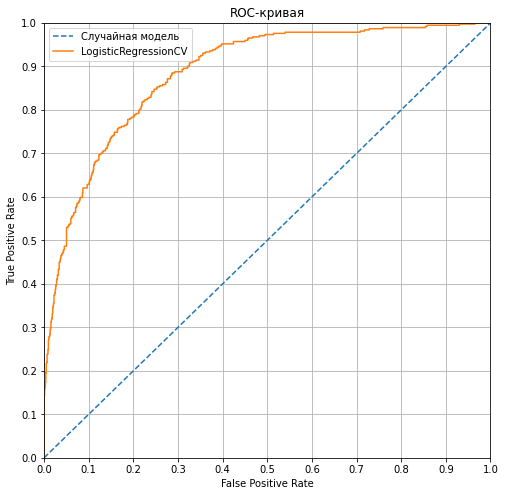

In [42]:
roc_auc_plot(logreg_model)

__Прогоним каждую последующую модель через optuna для выявления наилучших гиперпараметров через кросс-валидацию__

### Дерево решений

In [43]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

tree_model = DecisionTreeClassifier(random_state=777, class_weight='balanced', criterion='entropy')

params_tree = {
    'min_samples_leaf':opt_distr_int(2,100),
    'min_samples_split':opt_distr_int(2,100),
    'max_depth':opt_distr_int(2,25)
    }

start_time = time.time()

optuna_tree = OptunaSearchCV(
    tree_model, params_tree, n_trials=25,
    random_state=777, scoring='roc_auc')

optuna_tree.fit(X_train, y_train)

time_tuning_tree = round((time.time() - start_time)/60,2)
print(f'Время тюнинга модели: {time_tuning_tree} мин \n')

tree_model = optuna_tree.best_estimator_

print(f'Лучшие параметры Дерева решений: {optuna_tree.best_params_}')

/tmp/ipykernel_219/1638766123.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_tree = OptunaSearchCV(


Время тюнинга модели: 0.04 мин 

Лучшие параметры Дерева решений: {'min_samples_leaf': 80, 'min_samples_split': 64, 'max_depth': 8}


In [44]:
start_time = time.time()

tree_model.fit(X_train, y_train)

time_learn_tree = time.time() - start_time

print(f'Время обучения модели: {time_learn_tree:.4f}s')

Время обучения модели: 0.0170s


In [45]:
start_time = time.time()

predictions_tree = tree_model.predict(X_test)
predictions_proba_tree = tree_model.predict_proba(X_test)[:,1]

time_predict_tree = time.time() - start_time

print(f'Время предсказания модели: {time_predict_tree:.4f}s \n')

accuracy_tree = accuracy_score(y_test, predictions_tree)
roc_auc_tree = roc_auc_score(y_test, predictions_proba_tree)
print(f'Accuracy модели дерева решений: {accuracy_tree:.3f}')
print(f'ROC-AUC модели дерева решений: {roc_auc_tree:.3f}')

Время предсказания модели: 0.0216s 

Accuracy модели дерева решений: 0.775
ROC-AUC модели дерева решений: 0.851


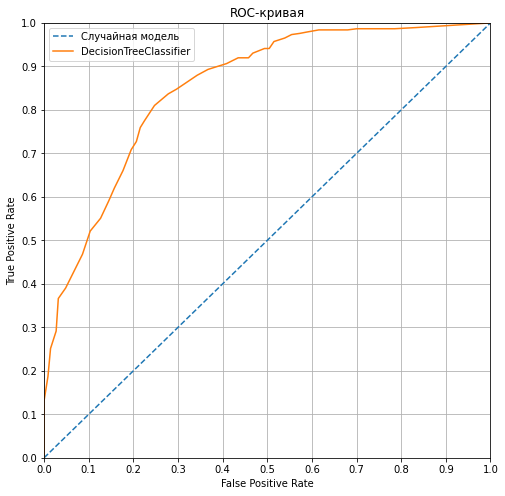

In [46]:
roc_auc_plot(tree_model)

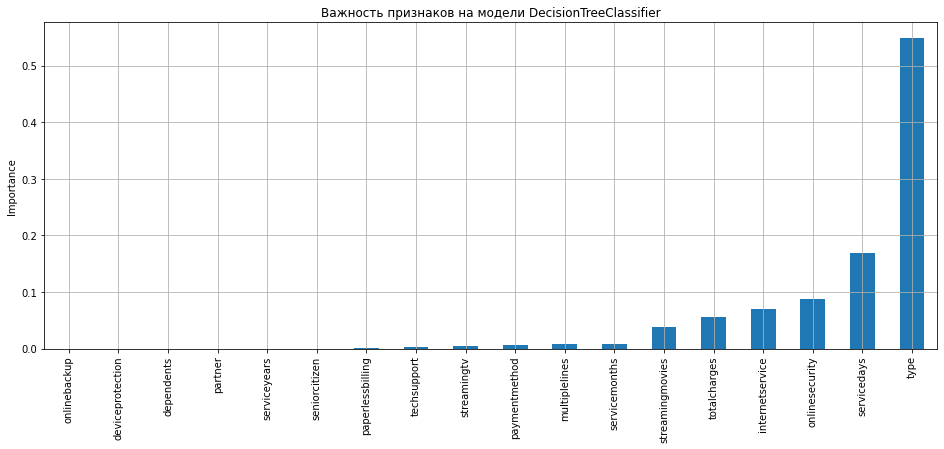

In [47]:
feat_importance_plot(tree_model, feature_names=features.columns)

### Случайный лес

In [48]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

forest_model = RandomForestClassifier(random_state=777, class_weight='balanced', criterion='entropy')

params_forest = {
    'min_samples_leaf':opt_distr_int(2,15),
    'min_samples_split':opt_distr_int(2,15),
    'max_depth':opt_distr_int(2,25),
    'n_estimators':opt_distr_int(100,300)
    }

start_time = time.time()

optuna_forest = OptunaSearchCV(
    forest_model, params_forest, n_trials=25,
    random_state=777, scoring='roc_auc')

optuna_forest.fit(X_train, y_train)

time_tuning_forest = round((time.time() - start_time)/60,2)
print(f'Время тюнинга модели: {time_tuning_forest} мин \n')

forest_model = optuna_forest.best_estimator_

print(f'Лучшие параметры Дерева Регрессии: {optuna_forest.best_params_}')

/tmp/ipykernel_219/3738678801.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_forest = OptunaSearchCV(


Время тюнинга модели: 1.86 мин 

Лучшие параметры Дерева Регрессии: {'min_samples_leaf': 4, 'min_samples_split': 10, 'max_depth': 10, 'n_estimators': 227}


In [49]:
start_time = time.time()

forest_model.fit(X_train, y_train)

time_learn_forest = time.time() - start_time

print(f'Время обучения модели: {time_learn_forest:.4f}s')

Время обучения модели: 1.0151s


In [50]:
start_time = time.time()

predictions_forest = forest_model.predict(X_test)
predictions_proba_forest = forest_model.predict_proba(X_test)[:,1]

time_predict_forest = time.time() - start_time

print(f'Время предсказания модели: {time_predict_forest:.4f}s \n')

accuracy_forest = accuracy_score(y_test, predictions_forest)
roc_auc_forest = roc_auc_score(y_test, predictions_proba_forest)
print(f'Accuracy модели Случайного леса: {accuracy_forest:.3f}')
print(f'ROC-AUC модели Случайного леса: {roc_auc_forest:.3f}')

Время предсказания модели: 0.1655s 

Accuracy модели Случайного леса: 0.788
ROC-AUC модели Случайного леса: 0.870


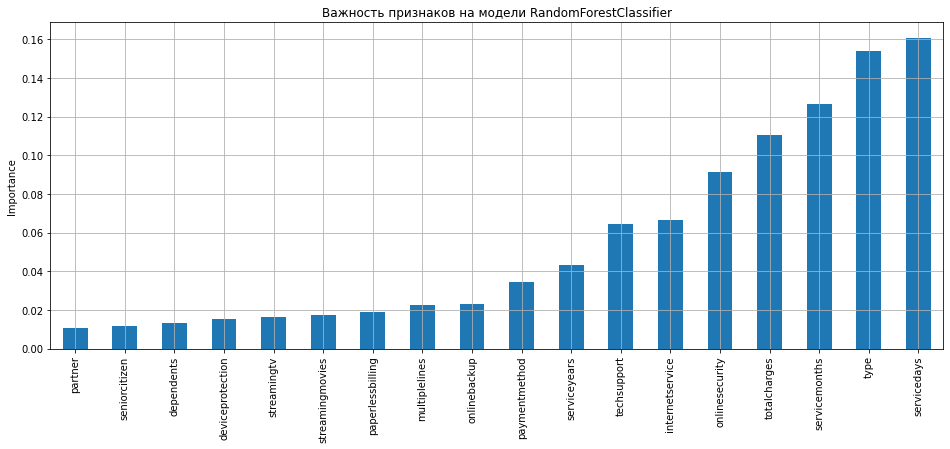

In [51]:
feat_importance_plot(forest_model, feature_names=features.columns)

### Catboost

In [52]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

cat_model = CatBoostClassifier(random_state=777, verbose=0, auto_class_weights='Balanced')

params_cat = {
    'iterations':opt_distr_int(100,300),
    'learning_rate':opt_distr_float(0.01,1.0),
    'depth':opt_distr_int(1,10),
    'min_data_in_leaf':opt_distr_int(1,10),
    'leaf_estimation_iterations':opt_distr_int(1,10)
    }

start_time = time.time()

optuna_cat = OptunaSearchCV(
    cat_model, params_cat, n_trials=25,
    random_state=777, scoring='roc_auc')

optuna_cat.fit(X_train, y_train)

time_tuning_cat = round((time.time() - start_time)/60, 2)
print(f'Время тюнинга модели: {time_tuning_cat} мин \n')

cat_model = optuna_cat.best_estimator_

print(f'Лучшие параметры CatBoostClassifier: {optuna_cat.best_params_}')

/tmp/ipykernel_219/405763122.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cat = OptunaSearchCV(


Время тюнинга модели: 2.3 мин 

Лучшие параметры CatBoostClassifier: {'iterations': 267, 'learning_rate': 0.6044669120650963, 'depth': 2, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 9}


In [53]:
start_time = time.time()

cat_model.fit(X_train, y_train)

time_learn_cat = time.time() - start_time

print(f'Время обучения модели: {time_learn_cat:.4f}s')

Время обучения модели: 1.1403s


In [54]:
start_time = time.time()

predictions_cat = cat_model.predict(X_test)
predictions_proba_cat = cat_model.predict_proba(X_test)[:,1]

time_predict_cat = time.time() - start_time

print(f'Время предсказания модели: {time_predict_cat:.4f}s \n')

accuracy_cat = accuracy_score(y_test, predictions_cat)
roc_auc_cat = roc_auc_score(y_test, predictions_proba_cat)
print(f'Accuracy модели CatBoostClassifier: {accuracy_cat:.3f}')
print(f'ROC-AUC модели CatBoostClassifier: {roc_auc_cat:.3f}')

Время предсказания модели: 0.0037s 

Accuracy модели CatBoostClassifier: 0.879
ROC-AUC модели CatBoostClassifier: 0.947


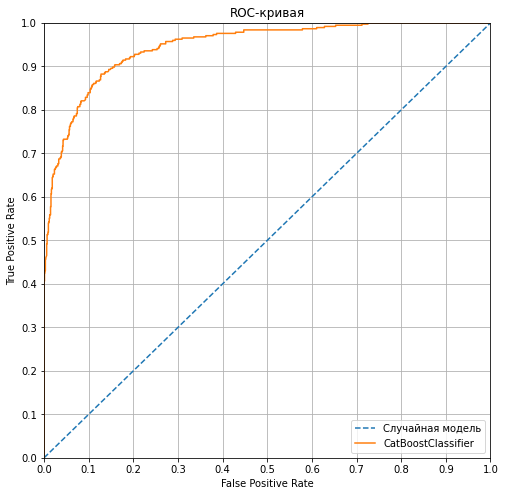

In [55]:
roc_auc_plot(cat_model)

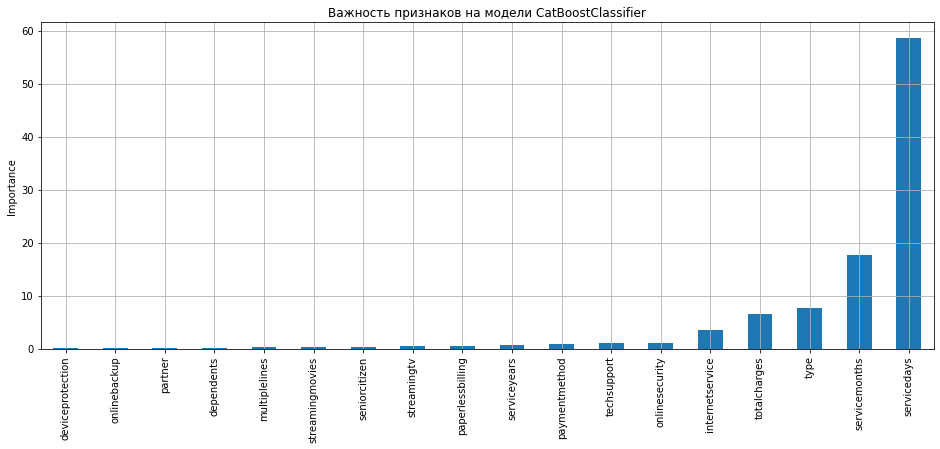

In [56]:
feat_importance_plot(cat_model, feature_names=features.columns)

### LightGBM

In [57]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model = LGBMClassifier(random_state=777, class_weight='balanced')

params_lgb = {
    'n_estimators':opt_distr_int(100,300),
    'learning_rate':opt_distr_float(0.01,1.0),
    'max_depth':opt_distr_int(1,10)
    }

start_time = time.time()

optuna_lgb = OptunaSearchCV(
    lgb_model, params_lgb, n_trials=25,
    random_state=777, scoring='roc_auc')

optuna_lgb.fit(X_train, y_train)

time_tuning_lgb = round((time.time() - start_time)/60, 2)
print(f'Время тюнинга модели: {time_tuning_lgb} мин \n')

lgb_model = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMClassifier: {optuna_lgb.best_params_}')

/tmp/ipykernel_219/3127287127.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_lgb = OptunaSearchCV(


Время тюнинга модели: 2.27 мин 

Лучшие параметры LGBMClassifier: {'n_estimators': 216, 'learning_rate': 0.8232343677600295, 'max_depth': 2}


In [58]:
start_time = time.time()

lgb_model.fit(X_train, y_train)

time_learn_lgb = time.time() - start_time

print(f'Время обучения модели: {time_learn_lgb:.4f}s')

Время обучения модели: 0.5914s


In [59]:
start_time = time.time()

predictions_lgb = lgb_model.predict(X_test)
predictions_proba_lgb = lgb_model.predict_proba(X_test)[:,1]

time_predict_lgb = time.time() - start_time

print(f'Время предсказания модели: {time_predict_lgb:.4f}s \n')

accuracy_lgb = accuracy_score(y_test, predictions_lgb)
roc_auc_lgb = roc_auc_score(y_test, predictions_proba_lgb)
print(f'Accuracy модели LGBMClassifier: {accuracy_lgb:.3f}')
print(f'ROC-AUC модели LGBMClassifier: {roc_auc_lgb:.3f}')

Время предсказания модели: 0.0934s 

Accuracy модели LGBMClassifier: 0.864
ROC-AUC модели LGBMClassifier: 0.936


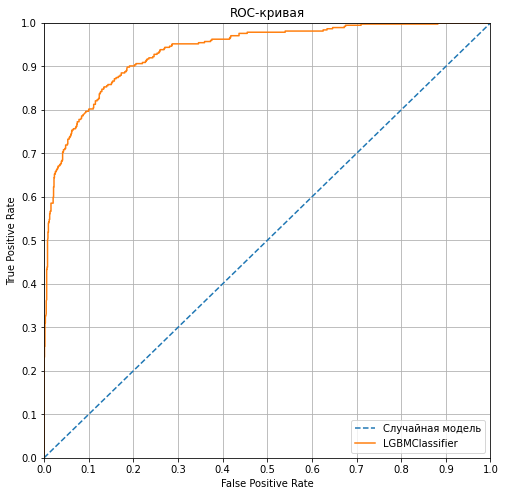

In [60]:
roc_auc_plot(lgb_model)

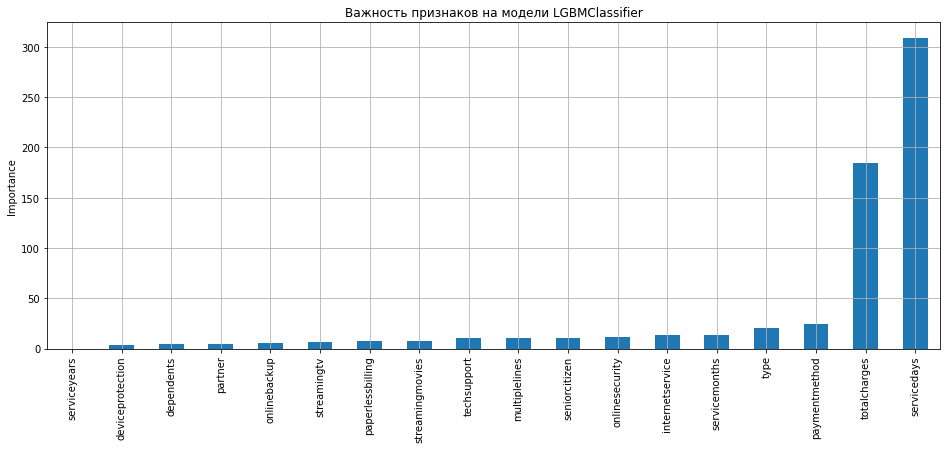

In [61]:
feat_importance_plot(lgb_model, feature_names=features.columns)

### Проверка на адекватность

In [62]:
for strat in ['most_frequent', 'prior', 'stratified', 'uniform']:
    model = DummyClassifier(strategy=strat, random_state=777)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)[:,1]
    accuracy_dummy = accuracy_score(y_test, predictions)
    roc_auc_dummy = roc_auc_score(y_test, predictions_proba)
    print(f'Accuracy модели пустышки при использовании стратегии {strat}: {accuracy_dummy:.3f}')
    print(f'ROC-AUC модели пустышки при использовании стратегии {strat}: {roc_auc_dummy:.3f}\n')

Accuracy модели пустышки при использовании стратегии most_frequent: 0.735
ROC-AUC модели пустышки при использовании стратегии most_frequent: 0.500

Accuracy модели пустышки при использовании стратегии prior: 0.735
ROC-AUC модели пустышки при использовании стратегии prior: 0.500

Accuracy модели пустышки при использовании стратегии stratified: 0.610
ROC-AUC модели пустышки при использовании стратегии stratified: 0.487

Accuracy модели пустышки при использовании стратегии uniform: 0.508
ROC-AUC модели пустышки при использовании стратегии uniform: 0.500



## Заключение

In [63]:
# Составим таблицу полученных показателей моделей

chars_logreg = [time_learn_logreg, time_predict_logreg, time_tuning_logreg, accuracy_logreg, roc_auc_logreg]
chars_tree = [time_learn_tree, time_predict_tree, time_tuning_tree, accuracy_tree, roc_auc_tree]
chars_forest = [time_learn_forest, time_predict_forest, time_tuning_forest, accuracy_forest, roc_auc_forest]
chars_catb = [time_learn_cat, time_predict_cat, time_tuning_cat, accuracy_cat, roc_auc_cat]
chars_lgb = [time_learn_lgb, time_predict_lgb, time_tuning_lgb, accuracy_lgb, roc_auc_lgb]

pd.DataFrame(
    data=[chars_logreg, chars_tree, chars_forest, chars_catb, chars_lgb],
    columns=['Время обучения, c','Время предсказания, с', 'Время тюнинга, мин', 'Accuracy', 'ROC_AUC'],
    index=['Логистическая регрессия', 'Дерево решений', 'Случайный лес','CatBoostClassifier', 'LightGBMClassifier']
)

,"Время обучения, c","Время предсказания, с","Время тюнинга, мин",Accuracy,ROC_AUC
Логистическая регрессия,18.920675,0.094987,NaN,0.773598,0.885129
Дерево решений,0.016990,0.021586,0.04,0.775018,0.850633
Случайный лес,1.015051,0.165467,1.86,0.787793,0.869738
CatBoostClassifier,1.140349,0.003693,2.30,0.879347,0.946993
LightGBMClassifier,0.591424,0.093381,2.27,0.863733,0.935835


Лучше всего показали себя модели градиентного бустинга Catboost и LightGBM. Несмотря на то, что LightGBMCLassifier обучается быстрее, чем CatBoostClassifier, предсказывает эта модель медленнее и ниже качеством.

В рамках решения задачи построения прототипа ML-модели, предсказывающей отток клиентов я бы рекомендовал к использованию модель CatBoostClassifier, которая даёт наилучшие по времени и качеству предсказания при оптимальном времени настройки гиперпараметров.